In [1]:
# https://pypi.python.org/pypi/pydot
# !pip install graphviz

In [2]:
import copy
import pandas as pd
import numpy as np
import json


import datetime as dt
import random
import time

import math
import bisect
import itertools


from IPython.display import clear_output


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from graphviz import Digraph
from scipy.ndimage import shift
#import pydot


from getpass import getpass
import os

import TransferEntropy_utils as te_utils
import K2_utils as K2_utils
import Utils as utils

In [3]:
def apply_first_diff(df):
    '''
        Function that applies first difference in a DataFrame. 
        Returns the DataFrame of the first difference
    '''
    dist_diff = df.diff()
    dist_diff.clip(lower=0, inplace=True)
    dist_diff.dropna(inplace=True)
    dist_diff.reset_index(drop=True, inplace=True)
    dist_diff = dist_diff.astype(int)
    
    return dist_diff

In [4]:
def get_significante_TEs(df, thresh):
    '''
        Returns a DataFrame with the most significants Transfer entropies based on a threshold. 
                Not sginifcant ones are set as zero.
        params:
            df - DataFrame of computed TransferEntropies
            thresh - Threshold of significance
    '''
    final_df = df.copy()
    for row in df.columns:
        for col in df.columns:
            if df[row][col] < thresh:
                final_df[row][col] = 0
                
    return final_df 

In [5]:
def compute_te_by_h(k,l,h_window, a,b):
    '''
        transentropy a->b
        te(k,l,h,a,b)
        k - dimension of b
        l - dimension of a
        h -> time window in the future of a [0..h]
    '''
    #joint_p_ih_ik_jl = joint_probability_new(k,l,h,a,b, lbl_a, lbl_b)
    
    te_by_h = []
    for h in np.arange(1,h_window):
        joint_p_ih_ik_jl = te_utils.joint_probability(k,l,h,a,b)

        joint_p_ih_ik = te_utils.joint_prob_ih_ik(k,l, joint_p_ih_ik_jl)
        conditional_num = te_utils.conditional_prob(k,l,joint_p_ih_ik_jl)
        conditional_den = te_utils.conditional_prob(k,0, joint_p_ih_ik)    
        div = te_utils.conditional_div(k,l,conditional_num, conditional_den)

        #log2 from the division of the conditionals -> #p(i_sub_t+h|i_sub_t**k, j_sub_t**l) /p(i_sub_t+h|i_t**k)
        log2_div_cond = np.log2(div[div!=0])
        te = np.sum(joint_p_ih_ik_jl[div!=0]*log2_div_cond)

        te_by_h.append(te)
        lag = np.argmax(te_by_h) + 1
    return [max(te_by_h),lag]

In [6]:
def compute_TE_and_lags_for_DataFrame(dist_df, h, k, l):
    '''
        Algorithm 1 - Generate graph of transferred entropies and relationship information delays
        
        Computation of transfer Entropy (TE) for a complete dataframe
        Params:
            dist_df : DataFrame of the variables to compute Transfer Entropy (TE)
            h: Window of time horizon. The TE will be computed varying h from 0 to h, the 'h' who provides
                maximum amount of entropy will be choosed by the method, and it will be set as highest transfer
                entropy lag
            l, k -  time horizons of TE
    '''
    start = time.process_time()
    transEntropy = np.zeros([dist_df.columns.size,dist_df.columns.size])
    lagEntropy = np.zeros([dist_df.columns.size,dist_df.columns.size])
    sigValues =  np.zeros([dist_df.columns.size,dist_df.columns.size])
    for i in np.arange(0, dist_df.columns.size):
        for j in np.arange(0, dist_df.columns.size):
            print('transfer entropy from ', dist_df.columns[i], ' to ', dist_df.columns[j])
            if(j != i + dist_df.columns.size/2 and j!=i and j != i - dist_df.columns.size/2):
                te_result = compute_te_by_h(k,l,h, dist_df[dist_df.columns[i]], dist_df[dist_df.columns[j]])
                transEntropy[i][j] = te_result[0]
                lagEntropy[i][j] = te_result[1]
                
            clear_output()
    end = time.process_time()   
    
    print('Time for the complete computation: ', end - start, ' seconds.')
    transEntropy_df = pd.DataFrame(transEntropy, columns = dist_df.columns, index = dist_df.columns)
    lagEntropy_df = pd.DataFrame(lagEntropy, columns = dist_df.columns, index = dist_df.columns)
    
    return [transEntropy_df, lagEntropy_df]  

In [7]:
def remove_cycles(graph):
    '''
        Algorithm 2 - Removal of Graph Cycles
        params:
            graph: The graph to remove cycles - (np.Matrix)
            
    '''
    graph_mat = copy.deepcopy(graph)
    grafo_ac = np.zeros([len(graph_mat), len(graph_mat)], dtype=float)
    ancestrals = [[] for el in np.arange(0, len(graph_mat))]
    
    max_val = max(graph_mat.flatten().tolist())
    print(max_val)
    idx_max = np.argmax(graph_mat.flatten().tolist())  

    while(max_val > 0):
        idx_row = int(np.floor(idx_max)/len(graph_mat))
        idx_col = idx_max - len(graph_mat)*idx_row

        impossible_nodes = []
        if ancestrals[idx_row]:
            impossible_nodes = get_node_genealogy(copy.deepcopy(ancestrals),idx_row, [])
            if not idx_col in impossible_nodes:
                grafo_ac[idx_row, idx_col] = graph_mat[idx_row, idx_col]
                ancestrals[idx_col] += [idx_row] 
        else:
            ancestrals[idx_col] += [idx_row]
            grafo_ac[idx_row,idx_col] = max_val

        graph_mat[idx_row, idx_col] = 0
        max_val = max(graph_mat.flatten().tolist())
        idx_max = np.argmax(graph_mat.flatten())
        
        
    return grafo_ac

In [8]:
def get_node_genealogy(genealogy, node, new_list):
    '''
        Algorithm 3 - Get node genealogy
        Generate the genealogy of a node-
        Params: 
            genealogy: The node genealogy - (Iniatially empty)
            node: The node to compute genealogy 
            new_list: 
    '''
    if np.all(np.unique(genealogy[node]) == ['x']):
        return new_list
    
    if not node in new_list:
        new_list.extend([node])
            
    if not genealogy[node]:
        return new_list
    else:
        for i,no in enumerate(genealogy[node]):       
            idx = no
            node_to_list = [genealogy[node][i]]
            genealogy[node][i] = 'x'
            if no == 'x':
                continue
            if 'x' in genealogy[no]:
                get_node_genealogy(genealogy, idx, new_list)   
            elif not genealogy[no]:
                new_list.extend(node_to_list)
                genealogy[no] = ['x']
                continue
            else:
                new_list.extend(node_to_list)
                get_node_genealogy(genealogy, idx, new_list)             
        else:
            return get_node_genealogy(genealogy, node, new_list)

In [9]:
def gen_common_and_virtual_parents(df,idx, summation, dict_lags, lista, dict_ways):
    '''
    
        Algorithm 4 - Generation of Common and Virtual Parents.
        
            Given a node, computes the delays and the paths between it and its virtual and common parents
            params:
                df: The dataframe representing the graph, where weights are the lags,
                summation: variable for lag summation
                dict_lags: Empty dictionary for storing the lags from the 
                    paths between a node and its common/virtual parents.
                lista: 
                dict_ways: Empty dictionary for storing the paths between a node and its common/virtual parents,
    '''
    lista.append(idx)
    if np.all(df[idx] == np.zeros(len(df))):
        return [dict_lags,dict_ways]
    for i,dad_lag in enumerate(df[idx]):
        if dad_lag > 0:
          
            summation += dad_lag
            try:
                dict_lags[df.columns[i]].append(summation)
                dict_ways[df.columns[i]].append(lista)
            except:
                dict_lags[df.columns[i]] = [summation]
                dict_ways[df.columns[i]]= [lista]
        
            gen_common_and_virtual_parents(df, df.columns[i], 
                                                       summation, dict_lags, 
                                                       lista[:], dict_ways)
            summation -= dad_lag
            
    return [dict_lags, dict_ways] 

In [10]:
def ensemble_nodes_parents(nodes, df):
    
    '''
        Algorithm 5 - Ensemble nodes parents.
    
        
        This algorithm compute commons and vitual parents for all the nodes in the nodes list.
            It returns a dictionary where for each key is a node and the value is
            the path between each node and its parent (common or virtual) along the summation
            of the lag from all the path.
            
        params:
            nodes: The list of nodes to compute common and virtual parents
            df: The dataframe representing the graph, where weights are the lags
    '''
    dic = {}
    for node in nodes:
        df_cp = df.copy()
#         if not np.all(mat_cp[node] == np.zeros(len(mat_cp))):
        dic[node] = gen_common_and_virtual_parents(df_cp, node, 0, {}, [],{})[0]
    return dic

In [11]:
def gen_k2_tree_from_lags(dici):
    '''
        Generate the K2 pre-order based on the dictionary of 
            lags/paths generated by ensemble_node_parents function
        params:
             dici: The dictionary with paths/lags from common and virtual parents
    '''
    tree_k2 = {}
    for key_son, value in dici.items():    
        if value:
            for key_dad, value_dad in value.items():
                for i, value in enumerate(value_dad):
                    try:
                        tree_k2[key_son].append(key_dad+"-"+str(i)+"_"+str(int(value)))
                    except:
                        tree_k2[key_son] = [key_dad+"-"+str(i)+"_"+str(int(value))]

                    tree_k2[key_dad+"-"+str(i)+"_"+str(int(value))] = []
        else:
            tree_k2[key_son] = []
    return tree_k2  
        


In [12]:
def generate_dataset_of_K2_iteration(df, node, dict_lag):
    '''
        Algorithm 6: 'Generate_dataset_of_K2_iteration'
        
            This algorithm generate the dataset that will be used in each K2 iteration. 
            It genrates a shifted dataset according with lag of highest transfer of entropy
            
            params:
                df: 
                node: Node to compute the dataframe shifted according to Lags
                dict_lag: A dictionary with the lags between the node and its parents
    '''
    df_gen = df.copy()
    if dict_lag[node]:
        for key_dad, values_dad in dict_lag[node].items():
            for i, val in enumerate(dict_lag[node][key_dad]): 
                df_gen[key_dad+"-"+str(i)+"_"+str(int(val))] = shift(df_gen[key_dad], int(val), order=0, mode='constant', cval=np.NaN)
    df_gen.dropna(inplace=True)
    return df_gen


In [13]:
def k2_modified(df_cases, dict_lags,tree_ogn, c=1):
    
    '''
        Algorithm 7 - K2-Modified
        K2_modified algorithm implementation
    
        params:
            df_cases: The dataframe of cases of the bayesian network, the columns are all the nodes 
            of the K2 pre-order 
            c: A factor for used in the evaluation of MDL score metric. Default = 1, (Optional)
    
        '''
    tree = copy.deepcopy(tree_ogn)
    dict_parents = {}
    
    dfs_list = []
      
    for col in df_cases.columns:
        dfs_list.append(generate_dataset_of_K2_iteration(df_cases, col, dict_lags))
    
  
    sigma = 0
    parents = [[] for node in df_cases.columns]
   
    count = 0
    for xi, col in enumerate(df_cases.columns):
        
        df = dfs_list[count]
        df.dropna(inplace=True)
        
        count += 1
        
        pold = K2_utils.f_mdl(df_cases, xi, parents[xi], c)
    
        tree_xi = []
        if tree:
              tree_xi = tree[col]
    
        f_ances = []
        while (True):
            test_parents = [parents[xi]+[ances] for ances in tree_xi] if tree_xi else []            
            f_ances = [K2_utils.f_mdl(df, xi,parent,c) for parent in test_parents] if test_parents else [K2_utils.f_mdl(df, xi, test_parents,c)]
            
            j_max = np.argmax(f_ances)

            sigma = f_ances[j_max]> pold
        
            if sigma:
                parents[xi] = parents[xi] + [no for no in [tree_xi[j_max]] if no not in parents[xi]]
                pold = f_ances[j_max]
  
            if tree_xi:
                del tree_xi[j_max]
      
            if(not sigma) or  (not tree_xi):
                break
        
    for i,parent in enumerate(parents):
        dict_parents[df_cases.columns[i]] = parent
    return dict_parents

In [14]:
def reconstruction_of_the_graph(df_lags, k2_return):
    '''
        Algorithm 8 - Reconstruction of the graph
        params:
            df_lags - DataFrame with lags of the relationships
                (Corresponds to the lags of graph with the most significant entropies and no cycles)
            k2_return - Resulting tree delivered by K2-Modified (Dictionary)
    
    '''
    df_clean = pd.DataFrame(data=np.zeros([len(df_lags.columns),len(df_lags.columns)], dtype=float), columns= df_lags.columns, index= df_lags.columns) 

    for key, values in k2_return.items():
        node_son = key
        lista_son = gen_common_and_virtual_parents(df_lags, node_son,0, {}, [], {})[1]

        for node in values:
            split_name = node.split('-')
            node_ref = split_name[0]
            lag = split_name[1].split('_')[1]
            idx_ref = int(split_name[1].split('_')[0])

            count = 0
            path_list = lista_son[node_ref][idx_ref][::-1]

            if len(lista_son[node_ref][idx_ref][::-1]) == 1:
                df_clean.at[node_ref,node_son] = 1
            while count < len(path_list) -1:
                df_clean.at[path_list[count], path_list[count+1]] = 1
                count +=1
            if not len(lista_son[node_ref][idx_ref][::-1]) == 1:
                df_clean.at[node_ref, path_list[0]] = 1
                
            df_clean = df_lags[df_clean>0].fillna(0)

    return df_clean

In [15]:
k2_mod_result = {}


def apply_methodology(k,l,h, t, alarms_df):
    '''
        Application of all the stages of the proposed Method on the case study
        params: 
            df_te - DataFrame with  transfer entropies of the relationships
                (Corresponds to the graph with the most significant entropies and no cycles)
            df_lags - DataFrame with lags of the relationships
                (Corresponds to the lags of graph with the most significant entropies and no cycles)
            alarms_df: DataFrame wih the industrial alarms that occurreddue to the disturbance application
    '''
    global k2_mod_result

    try:
        #"Because it takes a long time to run TE, we had already provided the datasets with TE and lags 
        #computed on the 'data', you can"
        with open("data/df_te.csv") as df_te, open("data/df_lags.csv") as df_lags:
            df_te = pd.read_csv(df_te, index_col=0)
            df_lags = pd.read_csv(df_lags, index_col=0)
    except:
        print("Files do not exist, computing Transfer Entropy for dataframe")
        df_te_and_lags = compute_TE_and_lags_for_DataFrame(alarms_df, h, k , l)
        df_te = df_te_and_lags[0]
        df_lags = df_te_and_lags[1]
        
    
    #Threshold proposed by the article -     t = 0.007668474476869511
    
    #Apply threshold on DataFrame (graph) of tranfer entropies
    te_significants = get_significante_TEs(df_te, t)
    
    
    #Removal of Cycles of graph of TransferEntropies
    te_no_cycle = pd.DataFrame(data = remove_cycles(te_significants.values), 
                                   columns=te_significants.columns, index=te_significants.columns)

    # Utilizing the graph containing the lags of the relationships
    te_lags_no_cycle = df_lags[te_no_cycle > 0].fillna(0)

    #Computing Common and Virtual Parents lags DataFrame
    dict_lags = ensemble_nodes_parents(te_lags_no_cycle.columns, te_lags_no_cycle)

    #Generation of K2 pre-order
    k2_tree = gen_k2_tree_from_lags(dict_lags)

    #Computation of Modified K2
    k2_mod_result = k2_modified(alarms_df,dict_lags, k2_tree,1)

    #Reconstruction of the final graph
    final_graph = reconstruction_of_the_graph(te_lags_no_cycle, k2_mod_result)
    return final_graph

In [16]:

#We have pre process this data applying a mooving mean of 5 samples, this is not an obligated stage, but you
#can do it by using the function apply_mooving_mean(df, mean) from utils.py script:

alarms = pd.read_csv("data/alarms_m5.csv", index_col=0)

#Parameters used in the case study of the article
k = 1
l = 1
h = 50
t = 0.007668474476869511

final_graph = apply_methodology(k, l, h, t, alarms)

Time for the complete computation:  11251.001657335  seconds.
0.1512784756129776


<ipython-input-8-ebe0155e337d>:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(np.unique(genealogy[node]) == ['x']):


In [17]:
final_graph

,x01_high,x02_high,x03_high,x06_high,x07_high,x08_high,x09_high,x21_high,x01_low,x02_low,x03_low,x06_low,x07_low,x08_low,x09_low,x21_low
x01_high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x02_high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x03_high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x06_high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x07_high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x08_high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x09_high,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
x21_high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,29.0,0.0,0.0,0.0
x01_low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x02_low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Saving the final graph
final_graph.to_csv('final_graph_latest.csv')

Final Graph


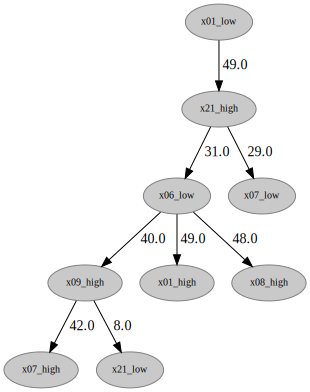

In [19]:
#Plot of graph of causal realationships
print('Final Graph')
utils.graph_simple(final_graph)